In [1]:
%%capture
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import Libraries

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os

# Set Constant

In [33]:
img_size = 130
batch_size = 32
channels = 3
epochs = 100
input_shape = (batch_size, img_size, img_size, channels)
n_classes = 3

# Import data into tensorflow dataset object¶


In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("/kaggle/input/plastic-paper-garbage-bag-synthetic-images/Bag Classes/Bag Classes",
                                                             seed=123,
                                                             shuffle=True,
                                                             image_size=(img_size, img_size),
                                                             batch_size=batch_size)

Found 15000 files belonging to 3 classes.


In [6]:
classes_name = dataset.class_names
print(classes_name)

['Garbage Bag Images', 'Paper Bag Images', 'Plastic Bag Images']


In [7]:
def delete_images(classname):
    return ''.join(classname.split()[:2])

classes_name=dataset.class_names
classes_name=list(map(delete_images,classes_name))

In [8]:
print(classes_name)

['GarbageBag', 'PaperBag', 'PlasticBag']


#  Image Sample

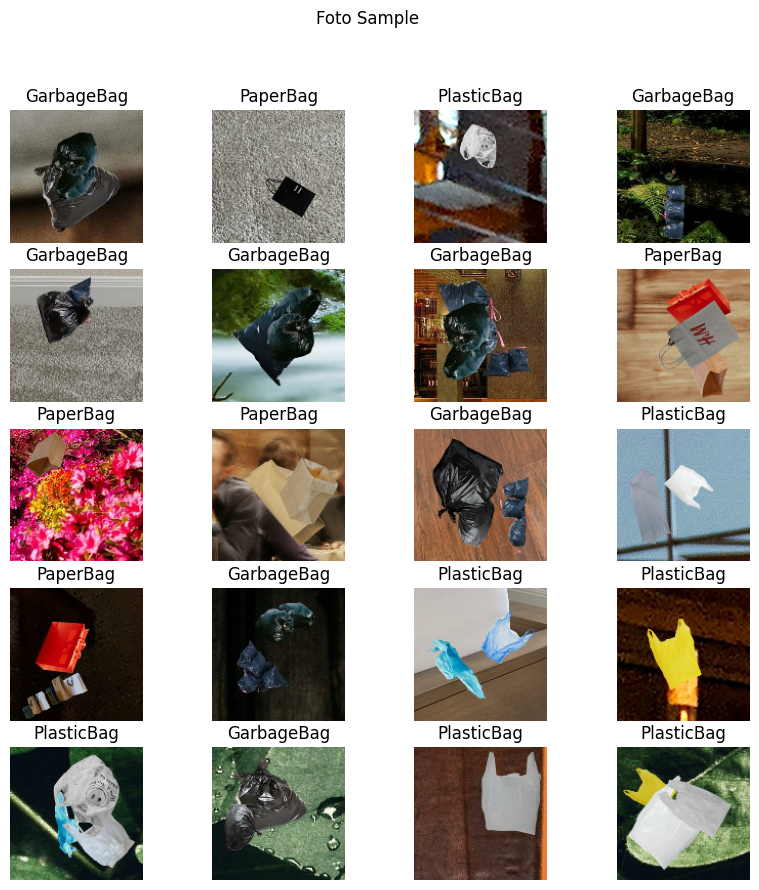

In [9]:
plt.figure(figsize=(10,10))
plt.suptitle("Foto Sample")
for batch_img, batch_label in dataset.take(1):
    for i in range(20):
        ax = plt.subplot(5,4,i+1)
        plt.title(classes_name[batch_label[i]])
        plt.imshow(batch_img[i].numpy().astype('uint8'))
        plt.axis('off')

In [10]:
def split_train_test_val(dataset,train_split=0.8,test_split=0.1,val_split=0.1,shuffle=True,shuffle_size=1000):
   assert (train_split + test_split + val_split) == 1

   ds_size = len(dataset)

   if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
    #set size of train,test and val
   train_size=int(train_split*len(dataset))
   test_size=int(test_split*len(dataset))
   val_size=int(val_split*len(dataset))

   train_ds=dataset.take(train_size)
   val_ds=dataset.skip(train_size).take(val_size)
   test_ds=dataset.skip(train_size+val_size)

   return train_ds,val_ds,test_ds

In [11]:
len(dataset)

469

In [13]:
train,val,test=split_train_test_val(dataset)

In [14]:
print('length of Training:',len(train),' batch')
print('-'*10)
print('length of Test:',len(test),' batch')
print('-'*10)
print('length of Validation:',len(val),' batch')

length of Training: 375  batch
----------
length of Test: 48  batch
----------
length of Validation: 46  batch


In [15]:
train_ds = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Creating a Layer for Resizing and Normalization¶


In [17]:
resize_and_scaling = tf.keras.Sequential([
    layers.Resizing(img_size, img_size),
    layers.Rescaling(1./255)
])

# Build The Model

In [19]:
base_model = EfficientNetB3(weights='imagenet',pooling='max',include_top=False, input_shape=(img_size, img_size, 3))

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [22]:
model = tf.keras.models.Sequential([
    resize_and_scaling,
    base_model,
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

In [25]:
model.build(input_shape=input_shape)

In [26]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 130, 130, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (32, 1536)             │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 64)               │        98,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,882,098 (41.51 MB)

 Trainable params: 10,794,795 (41.18 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [34]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callbacks= tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [35]:
history=model.fit(train_ds,validation_data=val_ds,epochs=epochs,batch_size=batch_size,verbose=1, callbacks=callbacks)

Epoch 1/100


I0000 00:00:1722570642.266479     770 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


375/375 ━━━━━━━━━━━━━━━━━━━━ 332s 433ms/step - accuracy: 0.8958 - loss: 0.4420 - val_accuracy: 0.3601 - val_loss: 3.2321
Epoch 2/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 46s 124ms/step - accuracy: 0.9923 - loss: 0.0236 - val_accuracy: 0.9062 - val_loss: 0.2940
Epoch 3/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 46s 123ms/step - accuracy: 0.9958 - loss: 0.0168 - val_accuracy: 0.9266 - val_loss: 0.3322
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 47s 125ms/step - accuracy: 0.9935 - loss: 0.0227 - val_accuracy: 0.9959 - val_loss: 0.0150
Epoch 5/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 46s 124ms/step - accuracy: 0.9963 - loss: 0.0150 - val_accuracy: 0.9103 - val_loss: 2.6390
Epoch 6/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.9913 - loss: 0.0349 - val_accuracy: 0.9993 - val_loss: 0.0036
Epoch 7/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.9992 - loss: 0.0028 - val_accuracy: 0.9959 - val_loss: 0.0189
Epoch 8/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 46s 123ms/step - accuracy: 0.9899 - loss: 0.03

In [36]:
model.evaluate(test_ds)

48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.9990 - loss: 0.0010  


[0.0012372821802273393, 0.9986979365348816]

# Show Model Performance

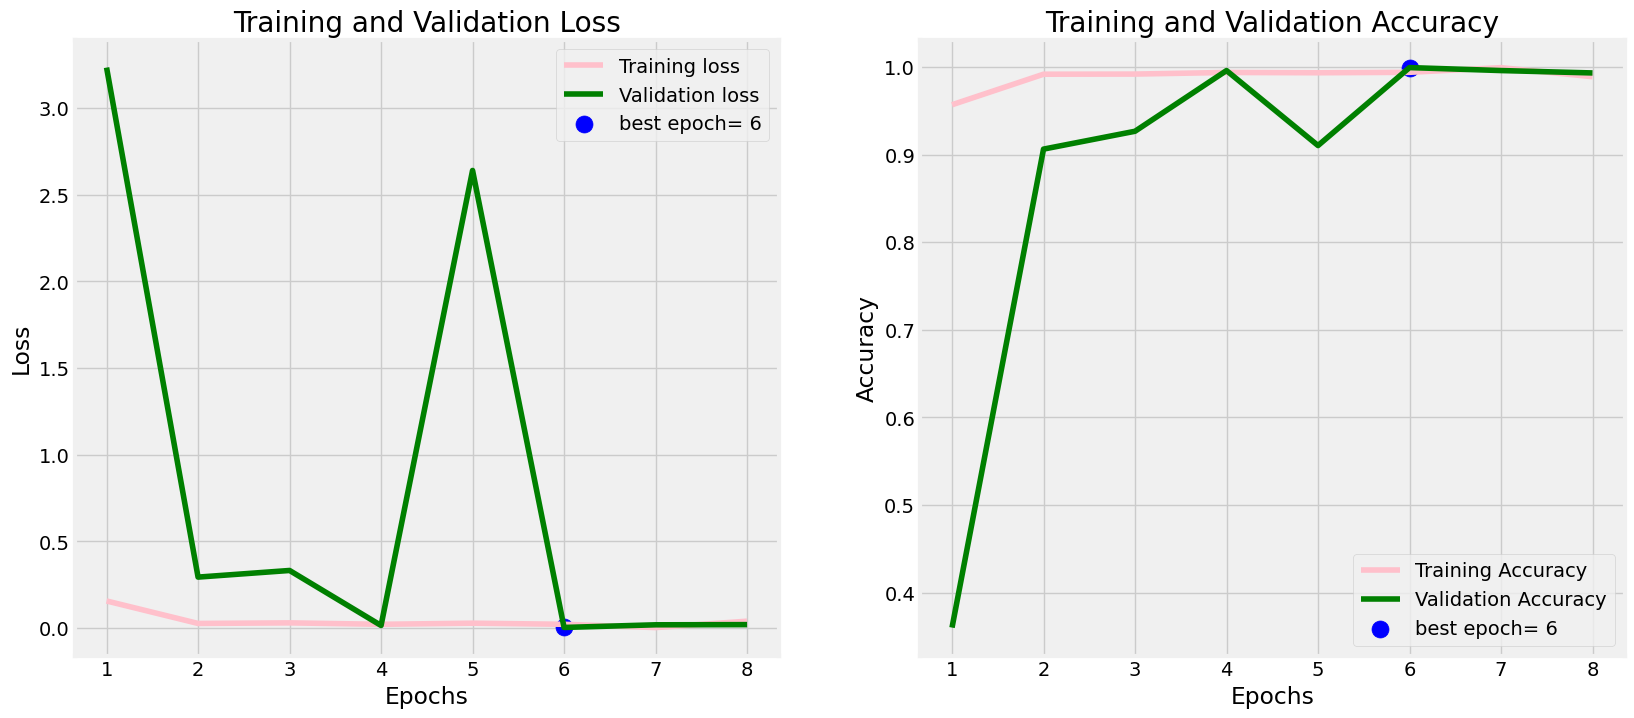

In [37]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'pink', label= 'Training loss')
plt.plot(Epochs, val_loss, 'green', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'pink', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'green', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# Evaluate The Model

In [38]:
train_score = model.evaluate(train_ds, verbose= 1)
valid_score = model.evaluate(val_ds, verbose= 1)
test_score = model.evaluate(test_ds, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.9990 - loss: 0.0021
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9997 - loss: 0.0018
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9990 - loss: 8.9650e-04
Train Loss:  0.0017287730006501079
Train Accuracy:  0.9992495179176331
--------------------
Validation Loss:  0.003619719762355089
Validation Accuracy:  0.9993206262588501
--------------------
Test Loss:  0.0012372820638120174
Test Accuracy:  0.9986979365348816


In [39]:
def get_predicitions(test_data):
    all_true_labels = []
    all_predicted_labels = []
    all_images=[]
    classes_name=dataset.class_names
    
    #get all the predictions and true labels
    for image_batch, label_batch in test_ds:
            # Make predictions on the batch
            predictions = model.predict(image_batch)

            # Convert predictions to class indices
            predicted_labels = np.argmax(predictions, axis=1)
            
            #append matrix of images
            all_images.extend(image_batch)

            # Convert true labels to numpy array
            true_labels = label_batch

            all_true_labels.extend(true_labels)
            all_predicted_labels.extend(predicted_labels)
    


    #plot the predictions
    index=0
    plt.figure(figsize=(20, 20))
    plt.suptitle('Prediction of Bags!')
   
    for i in range(31,46):
        if index<15:
            ax=plt.subplot(5,3,index+1)
            color = 'green' if all_true_labels[i] == all_predicted_labels[i] else 'red'
            plt.title(f'true_class:{classes_name[all_true_labels[i]]}\npredicted_class{classes_name[all_predicted_labels[i]]}',color=color)
            plt.imshow(np.array(all_images[i]).astype('uint8'))
            plt.axis('off')
            index+=1
        else:
            index=0

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━

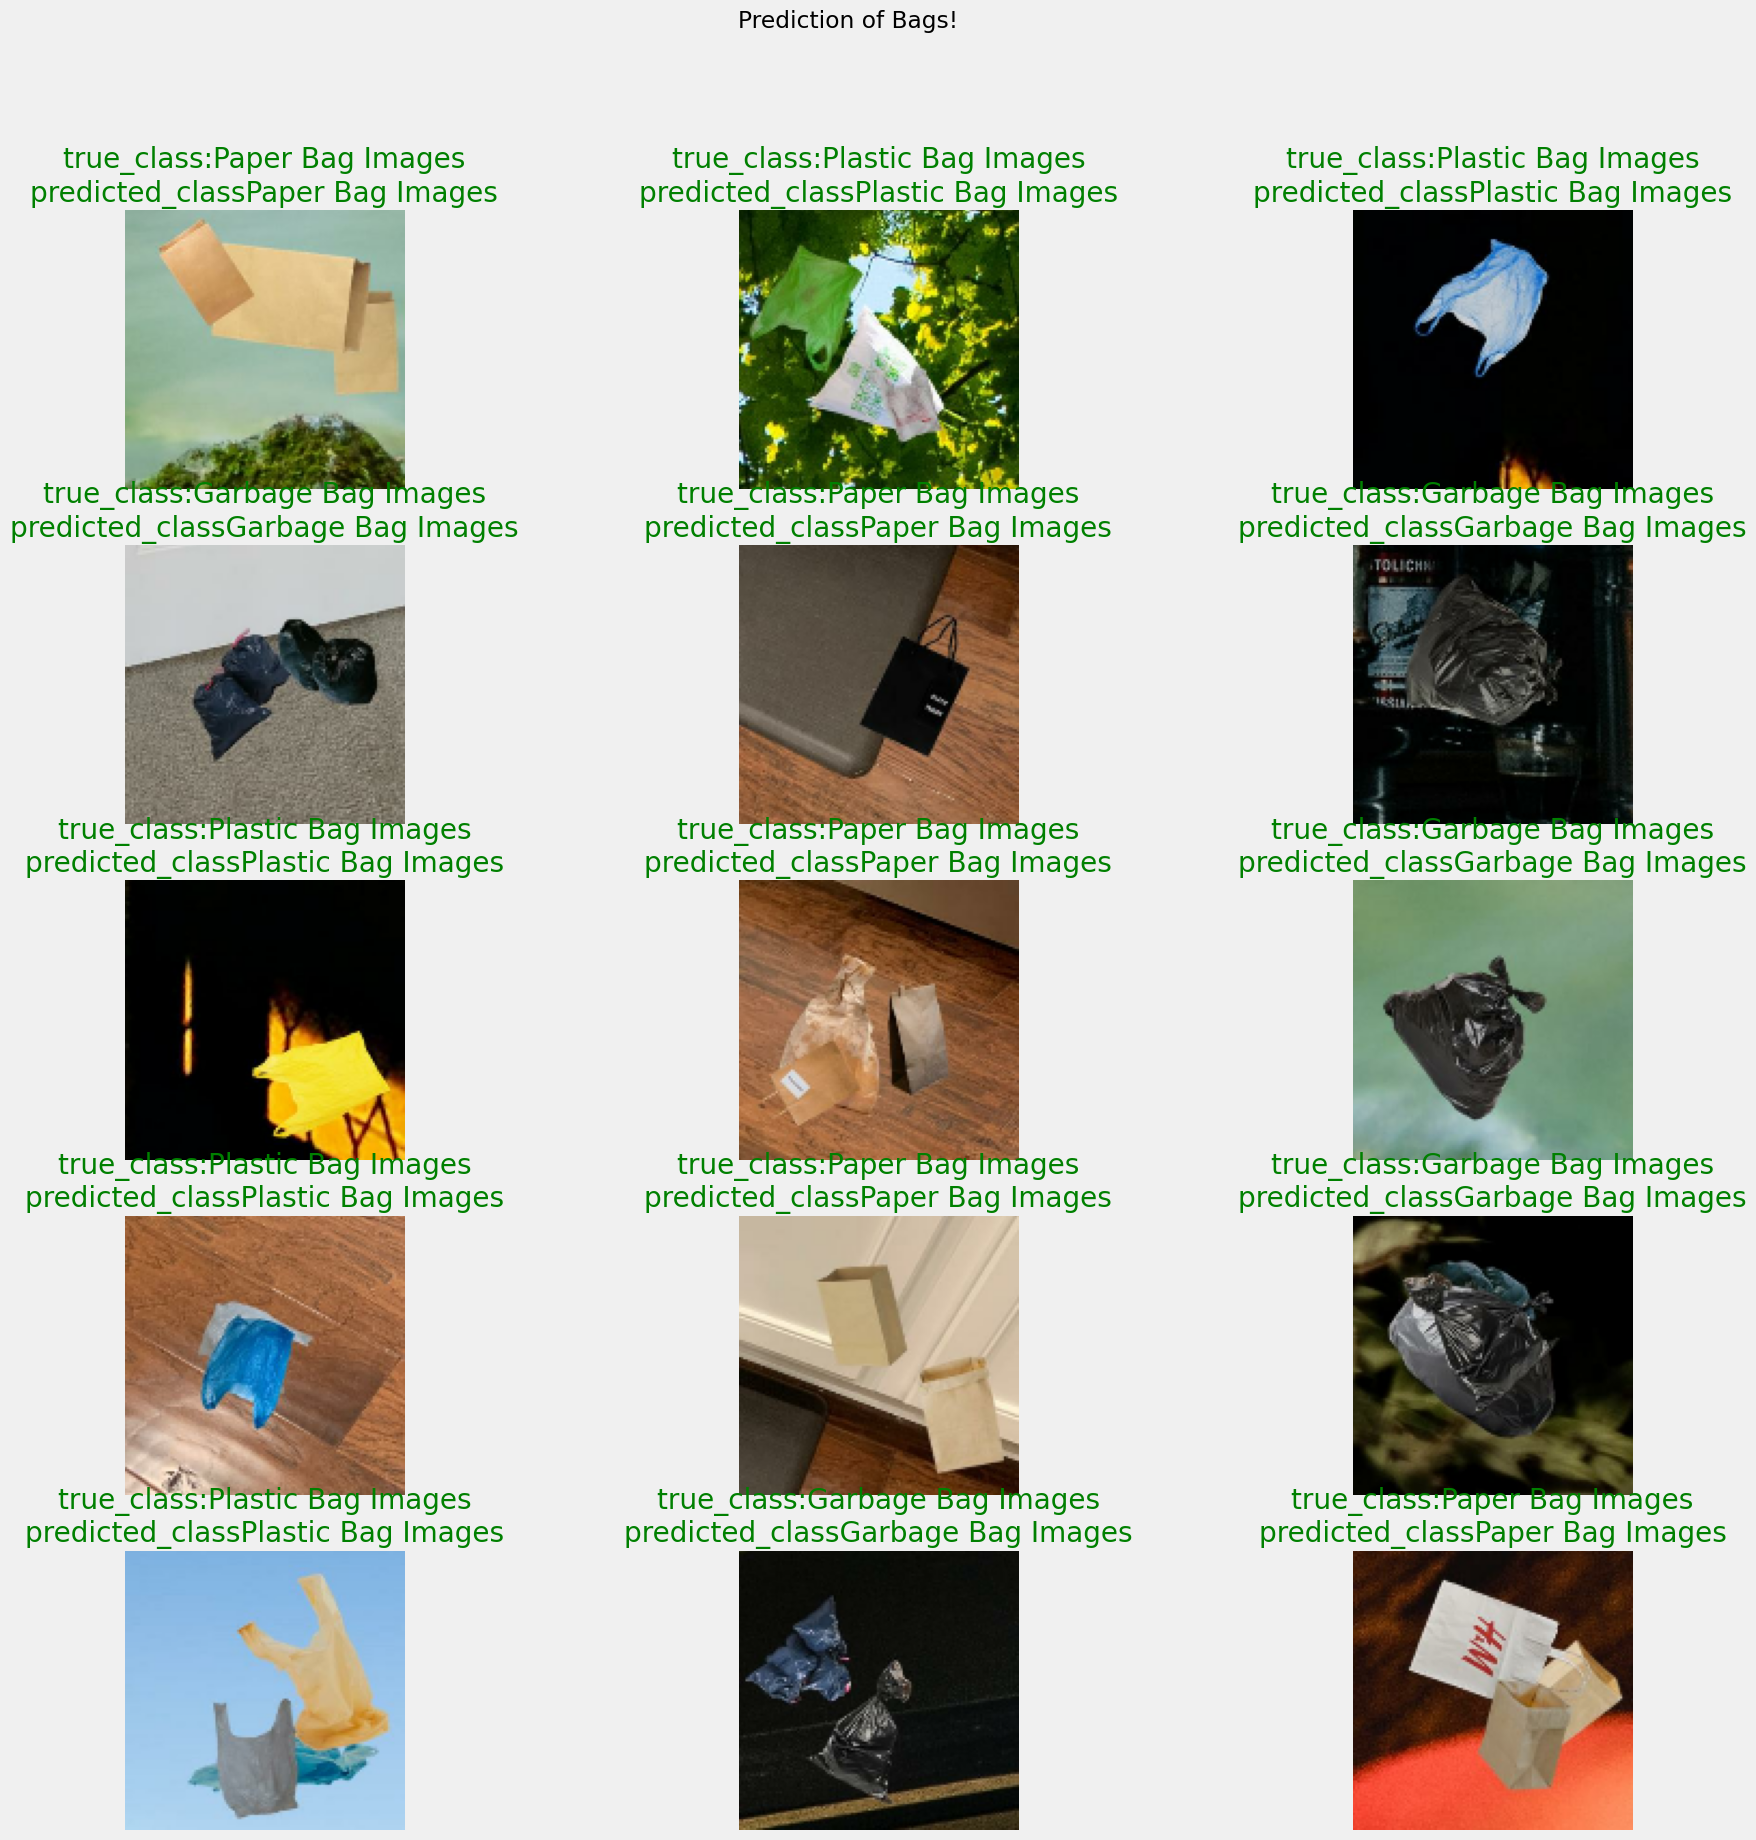

In [40]:
get_predicitions(test_ds)


# Show The Confusion Matrix!

In [41]:
def display_conf_matrix():
    all_true_labels=[]
    all_predicted_labels=[]
    for image_batch, label_batch in test_ds:
        # Make predictions on the batch
        predictions = model.predict(image_batch)

        # Convert predictions to class indices
        predicted_labels = np.argmax(predictions, axis=1)

        # Convert true labels to numpy array
        true_labels = label_batch.numpy()

        all_true_labels.extend(true_labels)
        all_predicted_labels.extend(predicted_labels)

    # Convert lists to numpy arrays
    all_true_labels = np.array(all_true_labels)
    all_predicted_labels = np.array(all_predicted_labels)    
    conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

        # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.class_names, yticklabels=dataset.class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show() 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

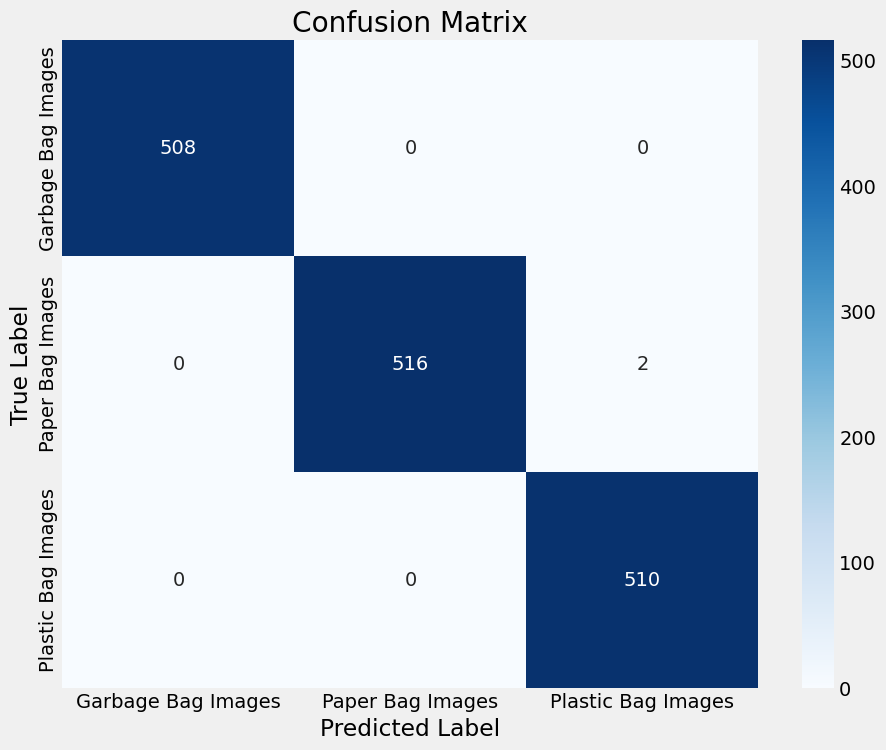

In [42]:
display_conf_matrix()